In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [4]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [5]:
Time = np.arange(0,200)

# Plotting features

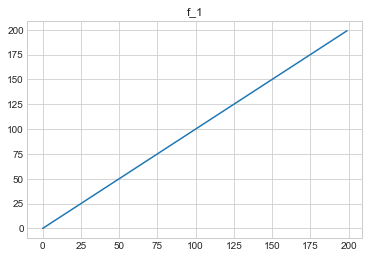

In [6]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

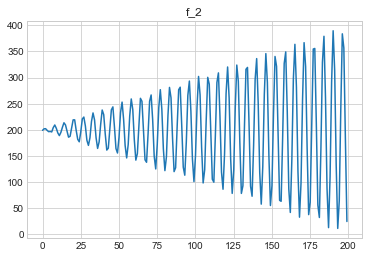

In [7]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

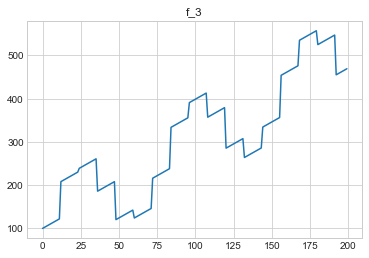

In [8]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

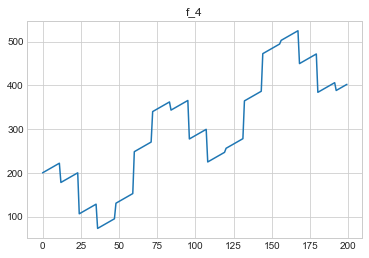

In [9]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Plotting time-series

In [10]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

In [11]:
Exog.shape

(200, 4)

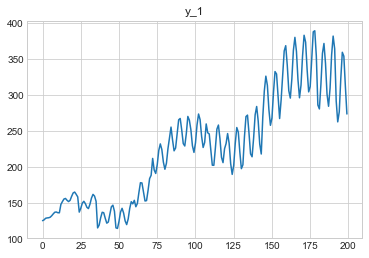

In [12]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

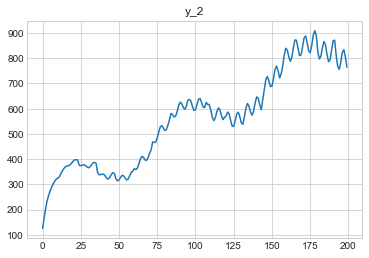

In [13]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Preprocessing of data

In [14]:
data_1 = pd.DataFrame(y_1)
data_1.columns = ["y"]
data_1["ds"] = pd.date_range(start='1/1/2018', periods=len(data_1), freq='M')

data_2 = pd.DataFrame({"y": y_2})
data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data_1.shape, data_2.shape, exog.shape)

(200, 2) (200, 2) (200, 5)


In [15]:
data_1.head()

,y,ds
0,125.175828,2018-01-31
1,126.310841,2018-02-28
2,128.504824,2018-03-31
3,129.027914,2018-04-30
4,129.241621,2018-05-31


In [16]:
data_2.shape

(200, 2)

In [17]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,200.703310,100.0,200.0,2018-01-31
1,1.0,200.243366,102.0,202.0,2018-02-28
2,2.0,204.019297,104.0,204.0,2018-03-31
3,3.0,201.111657,106.0,206.0,2018-04-30
4,4.0,196.966483,108.0,208.0,2018-05-31


In [18]:
N = 100

data_train_1 = data_1.iloc[:N]
data_test_1 = data_1.iloc[N:]

data_train_2 = data_2.iloc[:N]
data_test_2 = data_2.iloc[N:]

exog_train = exog.iloc[:N]
exog_test = exog.iloc[N:]

In [19]:
y_test_1 = data_test_1["y"].values
del data_test_1["y"]

y_test_2 = data_test_2["y"].values
del data_test_2["y"]

# Grid of parameters

In [20]:
p = range(1, 5)
#d= range(1, 4)
d = [1]
q = range(0, 5)

P = range(0, 6)
D = [0]
#D = range(0, 3)
Q = range(1, 6)

s = [12] # season length is still 24


# creating list with all the possible combinations of parameters

parameters = product(p, d, q, P, D, Q, s)
parameters_list = list(parameters)
len(parameters_list)

600

# GridSearch Sarima Approach

In [21]:
def calculate_criterion(model, mode = 'aic'):
    
    """
    Calculate criterion
    """
    
    if mode == "aic":
        return model.aic
    
    elif mode == "bic":
        return model.bic
        
    elif mode == "hqic":
        return model.hqic
    
    else:
        print("We don't support this mode")
        return None

In [22]:
def SARIMAX_Greed_Search(y, exog, parameters_list, trend = 'c', criterion_mode = "aic"):
    
    """
        Return dataframe with parameters and corresponding criterion
        
        parameters_list - list with (p, d, q, P, D, Q, s) tuples
        
        trend: 'n', 'c', 't', 'ct'
        
        criterion_mode = "aic", "bic", "hqic"
    """
    
    results = []
    
    best_criterion = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, exog = exog, order=(param[0], param[1], param[2]), 
                        seasonal_order=(param[3], param[4], param[5], param[6]), trend = trend).fit(disp=-1)
        except:
            continue
        
        criterion = calculate_criterion(model, criterion_mode)
        
        # saving best model, AIC and parameters
        
        if criterion < best_criterion:
            best_model = model
            best_criterion = criterion
            best_param = param
        
        results.append([param, calculate_criterion(model, criterion_mode)])

    result_table = pd.DataFrame(results)
    
    if result_table.empty == False:
        result_table.columns = ['parameters', criterion_mode]
    
    # sorting in ascending order, the lower AIC is - the better
        result_table = result_table.sort_values(by = criterion_mode, ascending=True).reset_index(drop=True)
    
    return result_table

# 1 Experiment: 1-st dataset without exog

In [23]:
%%time
results = SARIMAX_Greed_Search(data_train_1["y"], None, parameters_list, 'c', "bic")

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit


CPU times: user 39.2 s, sys: 1.91 s, total: 41.1 s
Wall time: 39.9 s


In [24]:
results.head()

,parameters,bic
0,"(4, 1, 0, 3, 0, 1, 12)",380.374588
1,"(4, 1, 1, 3, 0, 1, 12)",398.115786
2,"(3, 1, 0, 3, 0, 1, 12)",398.589846
3,"(2, 1, 3, 3, 0, 1, 12)",403.348892
4,"(3, 1, 1, 3, 0, 1, 12)",413.838739


**best model for the first experiment.**

In [25]:
best_params = results.iloc[0]["parameters"]

In [26]:
model = sm.tsa.statespace.SARIMAX(data_train_1["y"], exog = None, order=(best_params[0], best_params[1], best_params[2]), 
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), trend = 'c').fit(disp=-1)

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(4, 1, 0)x(3, 0, 1, 12)   Log Likelihood                -167.212
Date:                            Wed, 11 Jul 2018   AIC                            354.423
Time:                                    15:55:00   BIC                            380.375
Sample:                                         0   HQIC                           364.923
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4711      0.758      4.579      0.000       1.985       4.957
ar.L1         -0.0181      0.124     -0.146      0.884      -0.261       0.225
ar.L2         -0.1636      0.071     -2.293      0.022      -0.303      -0.024
ar.L3         -0.7328      0.076     -9.655      0.000      -0.882      -0.584
ar.L4         -0.3221      0.128     -2.512      0.012      -0.573      -0.071
ar.S.L12       0.7187      0.256      2.804      0.005       0.216       1.221
ar.S.L24      -0.6071      0.276     -2.201      0.028      -1.148      -0.067
ar.S.L36      -0.3608      0.255     -1.417      0.156      -0.860       0.138
ma.S.L12       0.1112      0.341      0.326      0.744      -0.557       0.779
sigma2         0.4285      0.098      4.388      0.000       0.237       0.620
===================================================================================
Ljung-Box (Q):                      139.39   Jarque-Bera (JB):                39.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.67
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Plotting**

In [28]:
forecast = model.predict(100, 199)

In [29]:
mape = np.round(mean_absolute_percentage_error(forecast.values, y_test_1), 3)

mae = np.round(mean_absolute_error(forecast.values, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.044 
 MAE:  13.37


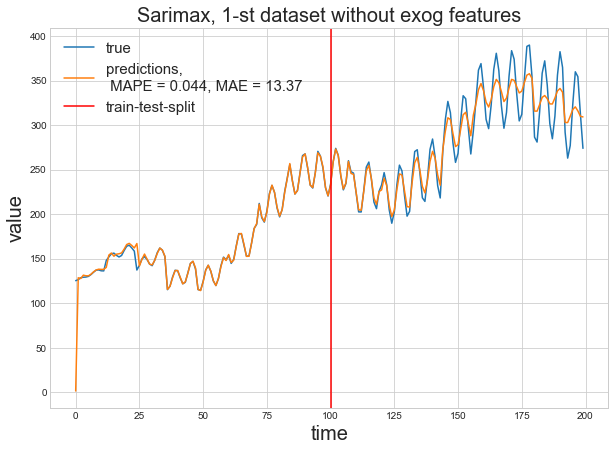

In [30]:
forecast_train = model.predict(0, 99)
forecast_test = model.predict(100, 199)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time, np.concatenate([forecast_train.values, forecast_test.values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 2 Experiment: 2-nd dataset without exog

In [33]:
%%time
results = SARIMAX_Greed_Search(data_train_2["y"], None, parameters_list, 'c', "bic")

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit


CPU times: user 2min 4s, sys: 3.78 s, total: 2min 8s
Wall time: 2min 6s


In [34]:
results.head()

,parameters,bic
0,"(3, 1, 2, 4, 0, 1, 12)",507.347862
1,"(3, 1, 2, 2, 0, 1, 12)",509.163024
2,"(4, 1, 0, 4, 0, 1, 12)",520.846918
3,"(4, 1, 1, 2, 0, 1, 12)",524.316582
4,"(4, 1, 1, 4, 0, 1, 12)",535.643358


In [35]:
best_params = results.iloc[0]["parameters"]

model = sm.tsa.statespace.SARIMAX(data_train_2["y"], exog = None, order=(best_params[0], best_params[1], best_params[2]), 
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), trend = 'c').fit(disp=-1)

model.summary()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(3, 1, 2)x(4, 0, 1, 12)   Log Likelihood                -226.103
Date:                            Wed, 11 Jul 2018   AIC                            476.206
Time:                                    15:57:30   BIC                            507.348
Sample:                                         0   HQIC                           488.806
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0079      0.038      0.210      0.833      -0.066       0.082
ar.L1          2.0512      0.012    166.131      0.000       2.027       2.075
ar.L2         -2.0468      0.014   -145.782      0.000      -2.074      -2.019
ar.L3          0.9789      0.010     99.660      0.000       0.960       0.998
ma.L1         -0.7264      0.084     -8.606      0.000      -0.892      -0.561
ma.L2          0.9185      0.128      7.204      0.000       0.669       1.168
ar.S.L12      -0.1229      0.616     -0.200      0.842      -1.330       1.084
ar.S.L24      -0.0414      0.558     -0.074      0.941      -1.134       1.051
ar.S.L36      -0.8212      0.499     -1.646      0.100      -1.799       0.157
ar.S.L48      -0.3491      0.185     -1.882      0.060      -0.713       0.015
ma.S.L12       0.9482      1.263      0.751      0.453      -1.527       3.424
sigma2         1.5741      1.009      1.561      0.119      -0.403       3.551
===================================================================================
Ljung-Box (Q):                       34.60   Jarque-Bera (JB):                62.99
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.39
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
forecast = model.predict(100, 199)

mape = np.round(mean_absolute_percentage_error(forecast.values, y_test_2), 3)

mae = np.round(mean_absolute_error(forecast.values, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.077 
 MAE:  54.365


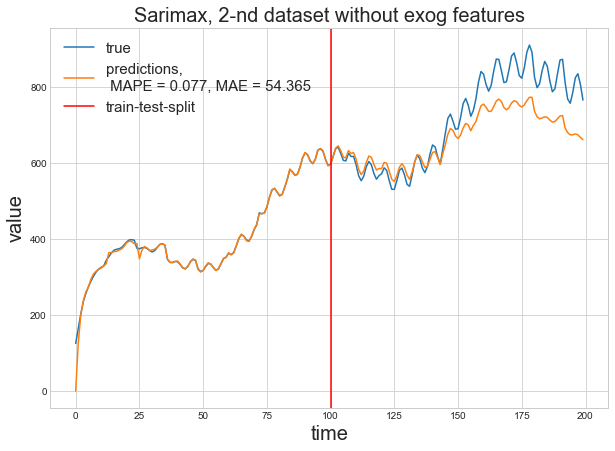

In [37]:
forecast_train = model.predict(0, 99)
forecast_test = model.predict(100, 199)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time, np.concatenate([forecast_train.values, forecast_test.values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 3-rd Experiment: 1-st dataset with exog features

In [38]:
# setting initial values and some bounds for them
ps = range(1, 5)
#d= range(1, 4)
d = [0]
qs = range(0, 5)

Ps = range(0, 6)
D = [0]
#D = range(0, 3)
Qs = range(1, 6)

s = [12]

# creating list with all the possible combinations of parameters

parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
len(parameters_list)

600

In [40]:
%%time
results = SARIMAX_Greed_Search(data_train_1["y"], 
        exog_train.loc[:, exog_train.columns != 'ds'], parameters_list, 'c', "hqic")

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



CPU times: user 54.7 s, sys: 3.07 s, total: 57.8 s
Wall time: 55.6 s


In [41]:
results.head()

,parameters,hqic
0,"(4, 0, 1, 0, 0, 1, 12)",-5940.121244
1,"(1, 0, 4, 0, 0, 1, 12)",-5931.629758
2,"(1, 0, 1, 0, 0, 1, 12)",-5931.226941
3,"(4, 0, 0, 0, 0, 1, 12)",-5924.766698
4,"(1, 0, 2, 0, 0, 1, 12)",-5924.560147


In [42]:
best_params = results.iloc[0]["parameters"]

model = sm.tsa.statespace.SARIMAX(data_train_1["y"], exog = exog_train.loc[:, exog_train.columns != 'ds'], order=(best_params[0], best_params[1], best_params[2]), 
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), trend = 'c').fit(disp=-1)

model.summary()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(4, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2988.387
Date:                            Wed, 11 Jul 2018   AIC                          -5952.774
Time:                                    15:59:22   BIC                          -5921.512
Sample:                                         0   HQIC                         -5940.121
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -5.13e-15   5.11e-15     -1.003      0.316   -1.52e-14    4.89e-15
f1             0.2500   1.09e-15   2.28e+14      0.000       0.250       0.250
f2             0.2500   5.95e-17    4.2e+15      0.000       0.250       0.250
f3             0.2500   1.52e-16   1.65e+15      0.000       0.250       0.250
f4             0.2500   1.39e-16   1.79e+15      0.000       0.250       0.250
ar.L1          0.4005   2.09e-19   1.91e+18      0.000       0.401       0.401
ar.L2          0.4499    9.8e-20   4.59e+18      0.000       0.450       0.450
ar.L3         -0.0524   6.16e-20   -8.5e+17      0.000      -0.052      -0.052
ar.L4          0.1416   3.93e-20   3.61e+18      0.000       0.142       0.142
ma.L1          0.1675   1.39e-19   1.21e+18      0.000       0.167       0.167
ma.S.L12       0.8914   1.96e-19   4.54e+18      0.000       0.891       0.891
sigma2      5.279e-28   1.96e-10    2.7e-18      1.000   -3.83e-10    3.83e-10
===================================================================================
Ljung-Box (Q):                      112.65   Jarque-Bera (JB):                12.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.60   Skew:                             0.51
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+35. Standard errors may be unstable.
"""

In [43]:
forecast = model.predict(100, 199, exog = exog_test.loc[:, exog_test.columns != 'ds'])

mape = np.round(mean_absolute_percentage_error(forecast.values, y_test_1), 3)

mae = np.round(mean_absolute_error(forecast.values, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.0 
 MAE:  0.0


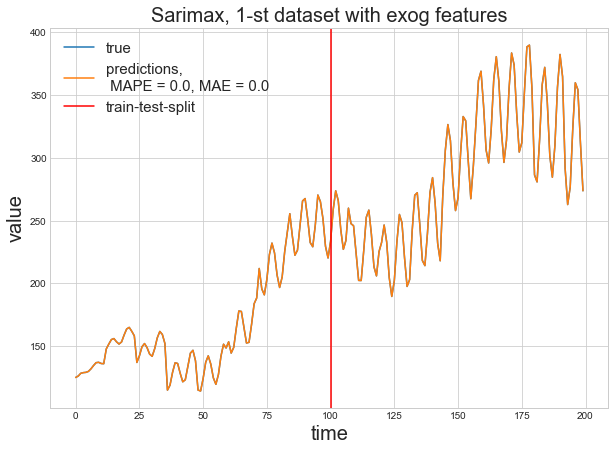

In [44]:
forecast_train = model.predict(0, 99, exog = exog_train.loc[:, exog_train.columns != 'ds'])
forecast_test = model.predict(100, 199, exog = exog_test.loc[:, exog_train.columns != 'ds'])

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time, np.concatenate([forecast_train.values, forecast_test.values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 4-th Experiment: 2-nd dataset with exog features

In [45]:
# setting initial values and some bounds for them
ps = range(1, 5)
#d= range(1, 4)
d = [1]
qs = range(0, 5)

Ps = range(0, 6)
D = [0]
#D = range(0, 3)
Qs = range(1, 6)

s = [12] # season length is still 24

# creating list with all the possible combinations of parameters

parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
len(parameters_list)

600

In [46]:
%%time
results = SARIMAX_Greed_Search(data_train_2["y"], 
                              exog_train.loc[:, exog_train.columns != 'ds'], parameters_list, 'c', "hqic")

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sergeymakarychev/anaconda/envs/deloit


CPU times: user 1min 16s, sys: 948 ms, total: 1min 17s
Wall time: 1min 18s


In [47]:
results.head()

,parameters,hqic
0,"(3, 1, 3, 2, 0, 1, 12)",335.706895
1,"(3, 1, 2, 2, 0, 1, 12)",340.800117
2,"(3, 1, 0, 2, 0, 1, 12)",348.930529
3,"(4, 1, 2, 2, 0, 1, 12)",350.059301
4,"(4, 1, 0, 2, 0, 1, 12)",352.755987


In [48]:
best_params = results.iloc[0]["parameters"]

model = sm.tsa.statespace.SARIMAX(data_train_2["y"], exog = exog_train.loc[:, exog_train.columns != 'ds'], order=(best_params[0], best_params[1], best_params[2]), 
        seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]), trend = 'c').fit(disp=-1)

model.summary()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(3, 1, 3)x(2, 0, 1, 12)   Log Likelihood                -144.979
Date:                            Wed, 11 Jul 2018   AIC                            319.957
Time:                                    16:00:43   BIC                            358.884
Sample:                                         0   HQIC                           335.707
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0018      0.026     -0.070      0.944      -0.052       0.049
f1             3.9804      8.913      0.447      0.655     -13.488      21.449
f2             0.1984      0.023      8.645      0.000       0.153       0.243
f3             0.2098      0.016     12.937      0.000       0.178       0.242
f4             0.2120      0.011     19.526      0.000       0.191       0.233
ar.L1          1.9849      0.064     30.783      0.000       1.859       2.111
ar.L2         -1.9175      0.091    -20.964      0.000      -2.097      -1.738
ar.L3          0.9047      0.062     14.670      0.000       0.784       1.026
ma.L1         -0.0755      0.100     -0.754      0.451      -0.272       0.121
ma.L2          0.5243      0.125      4.210      0.000       0.280       0.768
ma.L3          0.5218      0.159      3.291      0.001       0.211       0.833
ar.S.L12       1.0973      0.103     10.602      0.000       0.894       1.300
ar.S.L24      -0.8384      0.053    -15.703      0.000      -0.943      -0.734
ma.S.L12      -0.0795      0.239     -0.332      0.740      -0.548       0.389
sigma2         0.6792      0.098      6.903      0.000       0.486       0.872
===================================================================================
Ljung-Box (Q):                       46.00   Jarque-Bera (JB):                37.14
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
forecast = model.predict(100, 199, exog = exog_test.loc[:, exog_test.columns != 'ds'])

mape = np.round(mean_absolute_percentage_error(forecast.values, y_test_2), 3)

mae = np.round(mean_absolute_error(forecast.values, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.056 
 MAE:  38.342


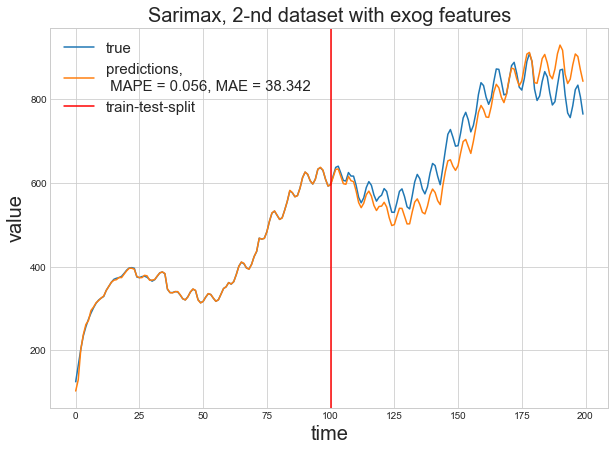

In [50]:
forecast_train = model.predict(0, 99, exog = exog_train.loc[:, exog_train.columns != 'ds'])
forecast_test = model.predict(100, 199, exog = exog_test.loc[:, exog_train.columns != 'ds'])

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time, np.concatenate([forecast_train.values, forecast_test.values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=100, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax, 2-nd dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Box-Cox transformation